## Sarcasm_Headlines

In [57]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, \
    nltk, collections, keras, lightgbm as lgb
from matplotlib import cm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression



In [58]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df['headline'][9]
#df.head()

'lots of parents know this scenario'

In [59]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [60]:
df.drop_duplicates(inplace=True)
df.isna().any()

is_sarcastic    False
headline        False
article_link    False
dtype: bool

In [61]:
#check if dataset is balanced
df["is_sarcastic"].value_counts()

0    14984
1    13633
Name: is_sarcastic, dtype: int64

# Remove Stopwords

In [62]:
stop = stopwords.words('english')
df['headline'] = df['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #CHTGPT

In [63]:
df['headline'][9]

'lots parents know scenario'

# Stemming

In [64]:
ps = PorterStemmer()
df['headline'] = df['headline'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

# Lemmetaization

In [65]:
#Lemmetaization of df['headline']
lemmatizer = WordNetLemmatizer()
df['headline'] = df['headline'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Data Exploration

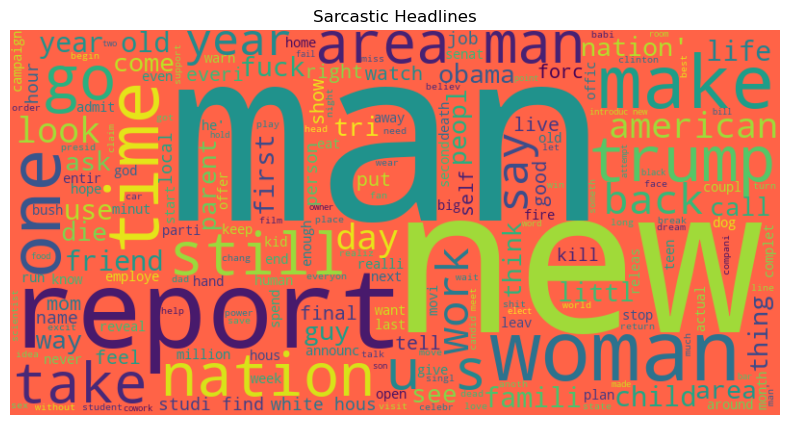

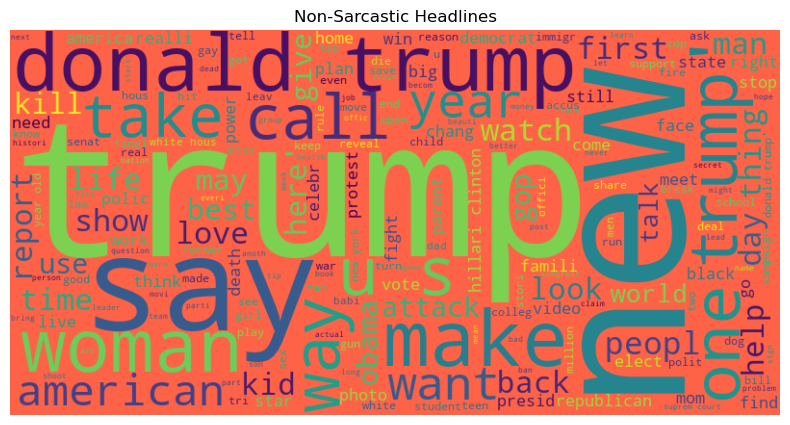

In [66]:
#CHTGPT
df_sarcastic = df[df['is_sarcastic'] == 1]
df_not_sarcastic = df[df['is_sarcastic'] == 0]

# Create a function to generate a word cloud plot
def plot_wordcloud(df_subset, title):
    # Concatenate all the headlines into a single string
    text = " ".join(headline for headline in df_subset['headline'])

    # Generate a word cloud object
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color="tomato").generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.savefig('plots/'+ title + '.png')
    plt.show()

# Generate the word cloud plot for sarcastic headlines
plot_wordcloud(df_sarcastic, "Sarcastic Headlines")

# Generate the word cloud plot for non-sarcastic headlines
plot_wordcloud(df_not_sarcastic, "Non-Sarcastic Headlines")


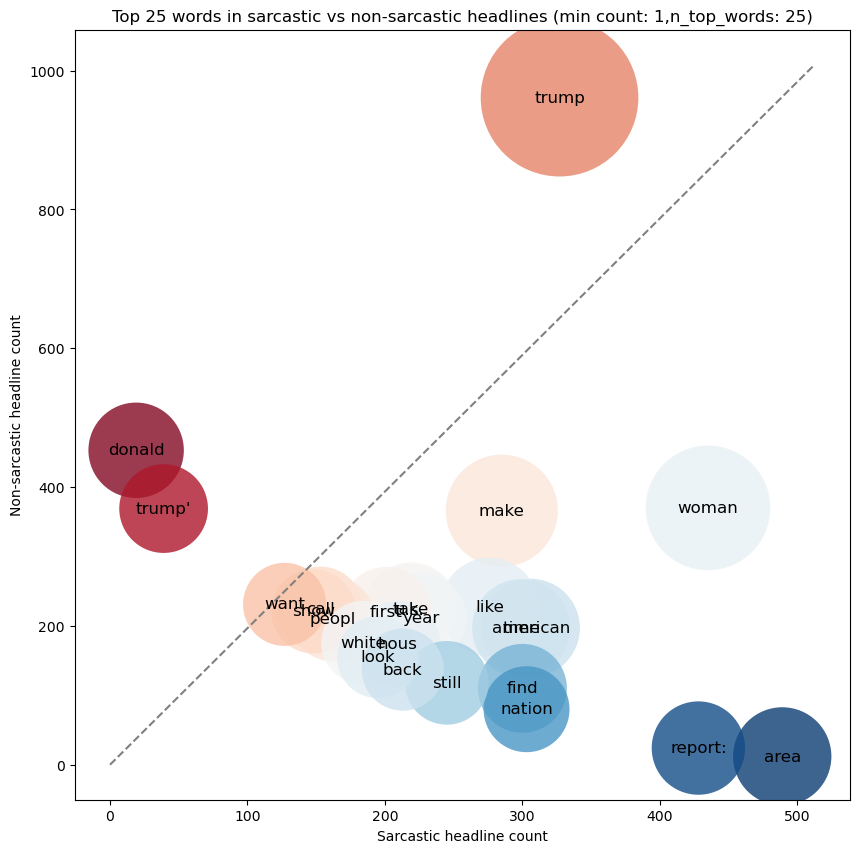

In [67]:
#CHGTPT
min_count = 1
n_top_words = 25

# Count the frequency of each word in sarcastic and non-sarcastic headlines
word_counts = {}
for index, row in df.iterrows():
    for word in row['headline'].split():
        if len(word) > 3:
            if word not in word_counts:
                word_counts[word] = {
                    'count_sarcastic': 0,
                    'count_non_sarcastic': 0,
                    'count_total': 0
                }
            word_counts[word]['count_total'] += 1
            if row['is_sarcastic'] == 1:
                word_counts[word]['count_sarcastic'] += 1
            else:
                word_counts[word]['count_non_sarcastic'] += 1

# Convert the word counts to a DataFrame
df_words = pd.DataFrame.from_dict(word_counts, orient='index')
df_words = df_words[df_words['count_total'] >= min_count]

# Sort the DataFrame by total count
df_words = df_words.sort_values('count_total', ascending=False)

# Select the top n words

df_words = df_words.nlargest(n_top_words, 'count_total')

# Compute the proportion of sarcastic headlines for each word
df_words['prop_sarcastic'] = df_words['count_sarcastic'] / df_words['count_total']

# Define the color map
cmap = cm.get_cmap('RdBu')
colors = cmap(df_words['prop_sarcastic'])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(
    x=df_words['count_sarcastic'], 
    y=df_words['count_non_sarcastic'], 
    s=df_words['count_total']*10,
    alpha=0.8,
    edgecolors='none',
    c=colors
)

# Add a 45-degree line starting from (0,0)
ax.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], ls='--', color='gray')

for index, row in df_words.iterrows():
    ax.annotate(row.name, 
                (row['count_sarcastic'], row['count_non_sarcastic']), 
                fontsize=12, 
                ha='center', 
                va='center')

ax.set_xlabel('Sarcastic headline count')
ax.set_ylabel('Non-sarcastic headline count')

ax.set_title(f'Top {n_top_words} words in sarcastic vs non-sarcastic headlines (min count: {min_count},n_top_words: {n_top_words})')

plt.savefig('plots/word_bubbles.png', dpi=300)
plt.show()



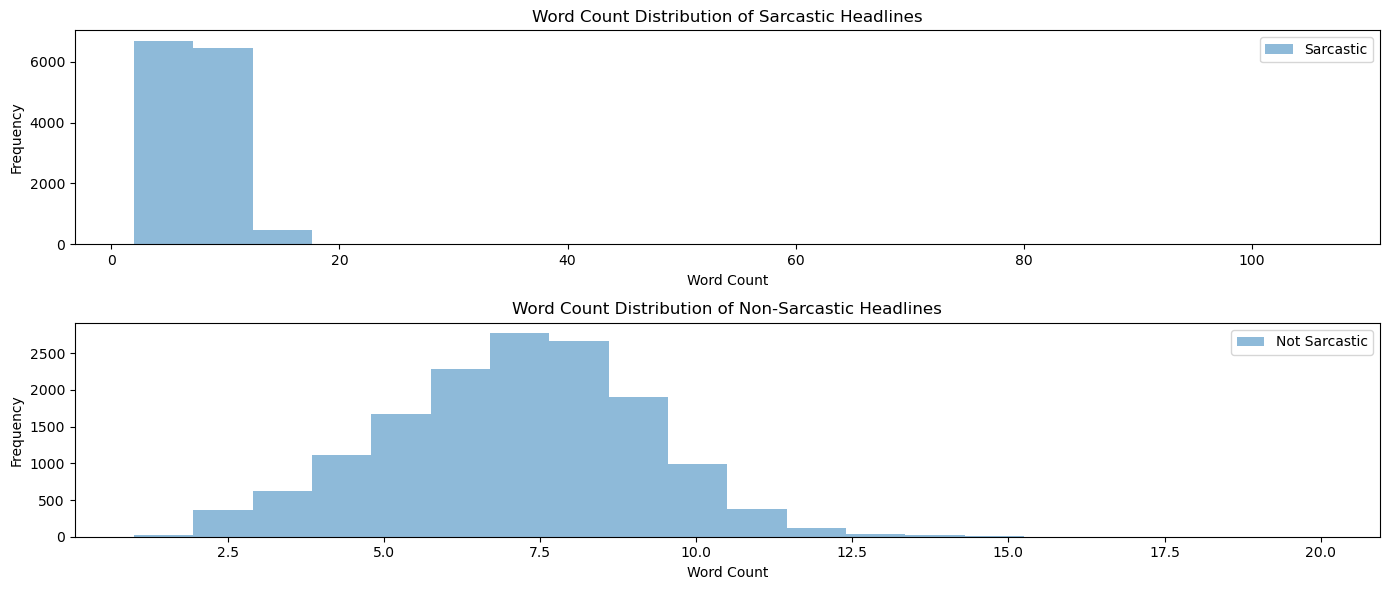

In [68]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))
ax[0].hist(df[df['is_sarcastic']==1]['headline'].apply(lambda x: len(x.split())), bins=20, alpha=0.5, label='Sarcastic')
ax[1].hist(df[df['is_sarcastic']==0]['headline'].apply(lambda x: len(x.split())), bins=20, alpha=0.5, label='Not Sarcastic')
ax[0].set_title('Word Count Distribution of Sarcastic Headlines')
ax[1].set_title('Word Count Distribution of Non-Sarcastic Headlines')
ax[0].set_xlabel('Word Count')
ax[1].set_xlabel('Word Count')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig('plots/word_count_hist_1.png', dpi=300)
plt.show()

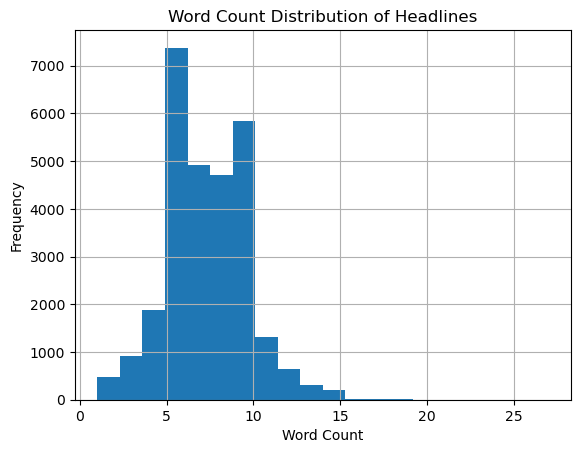

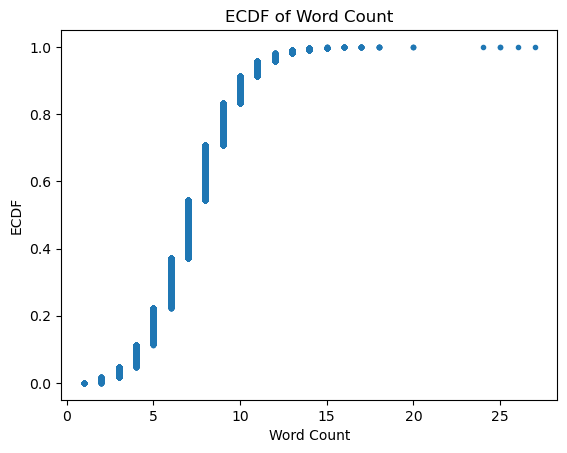

In [69]:
# Give column with max len
df['headline'].apply(lambda x: len(x.split())).idxmax()

# print the max len headline
df['headline'][df['headline'].apply(lambda x: len(x.split())).idxmax()]

# remove the max len headline column
df.drop(df['headline'].apply(lambda x: len(x.split())).idxmax(), inplace=True)

# histogram of len of headlines
df['headline'].apply(lambda x: len(x.split())).hist(bins=20)
plt.title('Word Count Distribution of Headlines')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.savefig('plots/word_count_hist_2.png', dpi=300)
plt.show()


# ecdf diagram of length of headlines
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

# Compute ECDF for word count
x, y = ecdf(df['headline'].apply(lambda x: len(x.split())))
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Word Count')
plt.ylabel('ECDF')
plt.title('ECDF of Word Count')
plt.savefig('plots/word_count_ecdf.png', dpi=300)
plt.show()



## NLP Approach

In [70]:
max_words = 100000
max_seq = 100000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['headline'].values)
sequences = tokenizer.texts_to_sequences(df['headline'].values)

In [71]:
#help from CHTGPT
padded_sequences = pad_sequences(sequences, maxlen=max_seq)


In [72]:
# Create tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['headline'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['headline'])


# find maxmimum number of words in a headline
maxlen = max([len(x) for x in sequences])
padded_sequences = pad_sequences(sequences, maxlen=maxlen)
print(padded_sequences.shape)
print(padded_sequences[5])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['is_sarcastic'], test_size=0.2, random_state=187,stratify=df['is_sarcastic'])
#validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=187,stratify=y_train)

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))

model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu6'))

model.add(Dense(1, activation='sigmoid'))


early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

#print all option for metric in model.compile
print(model.metrics_names)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy','Recall'])

model.summary()


# Train the model
history= model.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_val, y_val),callbacks=[early_stop])

(28616, 34)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   34 6068]
[]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 32)            3200000   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,226,945
Trainable params: 3,226,945
Non-trainable params: 0
_______________________________________________________

In [73]:
train_loss = model.evaluate(X_train, y_train)
val_loss = model.evaluate(X_val, y_val)
test_loss = model.evaluate(X_test, y_test)
print("Train set loss: ",(train_loss))
print("Validation set loss:",(val_loss))
print("Test set loss: ",(test_loss))

179/179 [==============================] - 1s 4ms/step - loss: 0.4382 - Accuracy: 0.7942 - recall: 0.7818
Train set loss:  [0.29627352952957153, 0.899688720703125, 0.895116925239563]
Validation set loss: [0.43971970677375793, 0.7984275817871094, 0.7973406910896301]
Test set loss:  [0.4382416009902954, 0.7941998839378357, 0.781811535358429]


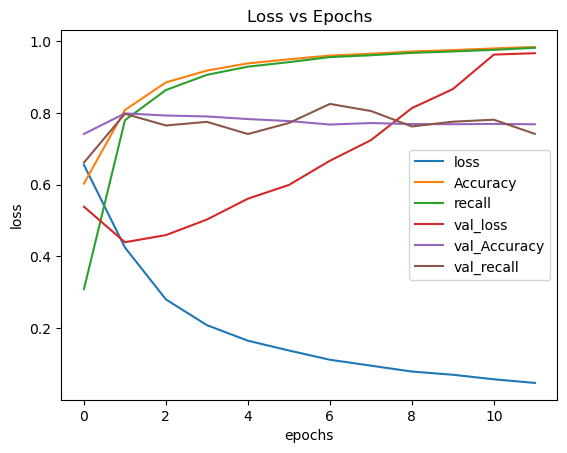

In [74]:
pd.DataFrame(history.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss vs Epochs')
plt.savefig('plots/loss.png', dpi=300)
plt.show()

179/179 [==============================] - 1s 4ms/step


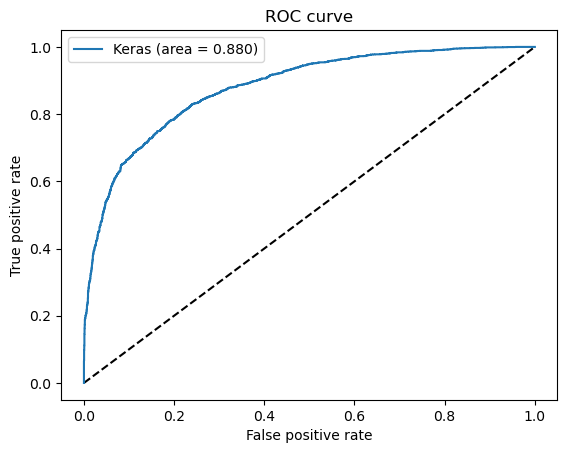

In [76]:




#plot ROC Kurve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('plots/ROC.png', dpi=300)
plt.show()


179/179 [==============================] - 1s 4ms/step
[[2414  583]
 [ 595 2132]]


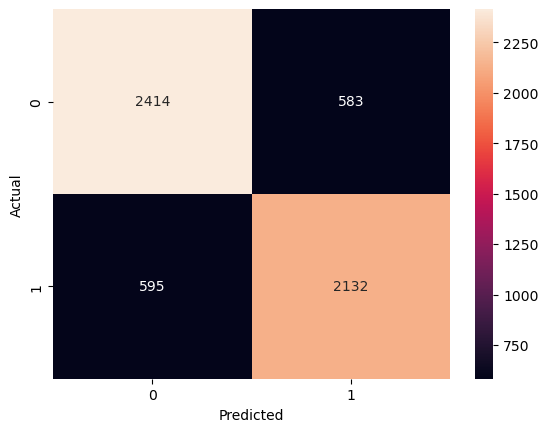

In [77]:
#confusion matrix with test_sets and matplotlib


y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('plots/confusion_matrix.png', dpi=300)
plt.show()




In [78]:

target_names = ['non-sarcastic', 'sarcastic']
print(classification_report(y_test, y_pred, target_names=target_names))



               precision    recall  f1-score   support

non-sarcastic       0.80      0.81      0.80      2997
    sarcastic       0.79      0.78      0.78      2727

     accuracy                           0.79      5724
    macro avg       0.79      0.79      0.79      5724
 weighted avg       0.79      0.79      0.79      5724



## ML- Approach

In [79]:
# build the lightgbm model

clf = lgb.LGBMClassifier(class_weight='balanced', metrics='recall')
clf.fit(X_train, y_train)
y_pred_lgbm=clf.predict(X_test)

accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_lgbm)))
y_pred_train = clf.predict(X_train)
y_pred_train = clf.predict(X_train)
print(classification_report(y_test, y_pred_lgbm, target_names=target_names))

LightGBM Model accuracy score: 0.6357
               precision    recall  f1-score   support

non-sarcastic       0.64      0.69      0.66      2997
    sarcastic       0.63      0.58      0.60      2727

     accuracy                           0.64      5724
    macro avg       0.63      0.63      0.63      5724
 weighted avg       0.64      0.64      0.63      5724



In [80]:
#logistic regression
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred_log=clf.predict(X_test)
print('Logistic Regression Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_log)))
print(classification_report(y_test, y_pred_log, target_names=target_names))



Logistic Regression Model accuracy score: 0.5449
               precision    recall  f1-score   support

non-sarcastic       0.54      0.85      0.66      2997
    sarcastic       0.56      0.21      0.31      2727

     accuracy                           0.54      5724
    macro avg       0.55      0.53      0.48      5724
 weighted avg       0.55      0.54      0.49      5724



c:\Users\benit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
